In [95]:
import fitsio as fio
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time as time

In [96]:
mem = fio.FITS('/lsst/troxel/y1a1/lgt5_member_mcal_combined.fits')[-1] # Member/shape catalog
clus = fio.FITS('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17_lgt5_desformat_catalog.fit')[-1] # Cluster catalog
cent = fio.FITS('/lsst/troxel/y1a1/central_member_shapes.fits')[-1] # Central/shape catalog
sat = fio.FITS('/lsst/troxel/y1a1/sat_member_shapes.fits')[-1] # Satellite/shape catalog

In [97]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Use standard cosmological model

In [98]:
# Slice to the galaxies of specified catalog and cluster
def get_clus(catalog, clus_id):
    clus_mems = catalog.read()[np.in1d(catalog['MEM_MATCH_ID'].read(), clus_id, assume_unique=False)]
    
    return clus_mems

In [99]:
# Slice to the central galaxy of specified cluster
def get_cent(clus_id):
    clus_cent = get_clus(cent, clus_id)
    
    return clus_cent

In [100]:
# Slice to satellite galaxies of specified cluster
def get_sat(clus_id):
    clus_sat = get_clus(sat, clus_id)
    
    return clus_sat

In [101]:
# Slice to specified column of satellite galaxies
def get_sat_prop(clus_id, prop):
    mask = sat['MEM_MATCH_ID'].read()==clus_id
    sat_prop = sat[prop].read()[mask]
    
    return sat_prop

In [102]:
# Calculate comoving distance
def co_distance(z):
    co_distance = cosmo.comoving_distance(z)
    
    return co_distance

In [103]:
# Calculate angular diameter distance
def ad_distance(z):
    ad_distance = co_distance(z) / (z + np.ones(len(z)))
    
    return ad_distance

In [104]:
# Calculate angular separation
def separation(clus_id):
    cent_pos = SkyCoord(np.ones(len(get_clus(mem, clus_id)['RA']))*get_clus(cent, clus_id)['RA']*u.deg, np.ones(len(get_clus(mem, clus_id)['DEC']))*get_clus(cent, clus_id)['DEC']*u.deg, frame='icrs')
    sat_pos = SkyCoord(get_clus(mem, clus_id)['RA']*u.deg, get_clus(mem, clus_id)['DEC']*u.deg, frame='icrs')
    sep = cent_pos.separation(sat_pos)
    
    return sep

In [105]:
# Calculate 3D distance
def distance_3d(clus_id):
    cent_distance = ad_distance(get_clus(cent, clus_id)['Z'])
    sat_distance = ad_distance(get_clus(mem, clus_id)['Z'])
    cent_pos = SkyCoord(np.ones(len(get_clus(mem, clus_id)['RA']))*get_clus(cent, clus_id)['RA']*u.deg, np.ones(len(get_clus(mem, clus_id)['DEC']))*get_clus(cent, clus_id)['DEC']*u.deg, distance=np.ones(len(get_clus(mem, clus_id)['Z']))*cent_distance, frame='icrs')
    sat_pos = SkyCoord(get_clus(mem, clus_id)['RA']*u.deg, get_clus(mem, clus_id)['DEC']*u.deg, distance=sat_distance, frame='icrs')
    sep_3d = cent_pos.separation_3d(sat_pos)
    
    return sep_3d

In [106]:
# Approximate 3D distance
def approx_distance(clus_id):
    ang_sep = separation(clus_id)
    cent_distance = ad_distance(get_clus(cent, clus_id)['Z'])
    approx_distance = np.radians(ang_sep) * cent_distance
    
    return approx_distance

In [107]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(e2, e1)/2
    
    return alpha

In [108]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    cent_id = cent['MEM_MATCH_ID'].read()
    sat_prop_full = sat[prop].read()
    sat_id, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
    new_array = np.zeros((231185,308))
    k = 0
    for i in range(231185):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [109]:
# Calculate satellite angular position for all satellite galaxies
def sat_ang_pos():
    sat_ra = sat_prop('RA')
    sat_dec = sat_prop('DEC')
    cent_ra = cent['RA'].read().reshape(231185,-1)
    cent_dec = cent['DEC'].read().reshape(231185,-1)
    x = sat_ra - cent_ra
    y = sat_dec - cent_dec
    sat_ang = np.arctan2(x, y)
    
    return sat_ang

In [110]:
# Calculate central galaxy alignment angle for all viable clusters
def cent_gal_ang():
    sat_pos_ang = sat_ang_pos()
    cent_pos_ang = pos_ang(cent['e1'].read(), cent['e2'].read()).reshape(231185,-1)
    theta = sat_pos_ang - cent_pos_ang
    theta = np.arcsin(np.absolute(np.sin(theta)))
    theta = np.degrees(theta)
    
    return theta

In [111]:
central_ang = cent_gal_ang()
mask = np.isfinite(central_ang)
central_ang = central_ang[mask]

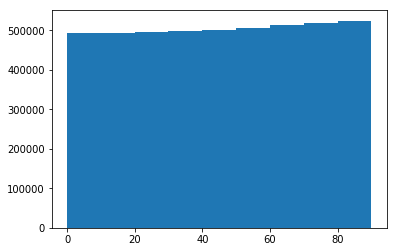

In [112]:
plt.hist(central_ang, bins=[0.,10.,20.,30.,40.,50.,60.,70.,80.,90.])
plt.show()

In [15]:
def quad_counts(clus_id, theta):
    sat_pos_ang = sat_ang_pos(clus_id)
    theta = theta * u.deg
    q1_count = np.sum(np.logical_and(np.less_equal(theta, sat_pos_ang), np.less(sat_pos_ang, theta+90*u.deg)))
    q2_count = np.sum(np.logical_and(np.less_equal(theta+90*u.deg, sat_pos_ang), np.less(sat_pos_ang, theta+180*u.deg)))
    q3_count = np.sum(np.logical_and(np.less_equal(theta+180*u.deg, sat_pos_ang), np.less(sat_pos_ang, theta+270*u.deg)))
    q4_count = np.sum(np.less_equal(theta+270*u.deg, sat_pos_ang)) + np.sum(np.less(sat_pos_ang, theta))
    
    return np.array([q1_count, q2_count, q3_count, q4_count])

In [16]:
def q_counts_array(clus_id, n):
    new_array = np.ones(n, dtype=[('angle',float)] + [('counts',float,(4,))] + [('chi_sq',float)])
    for i in range(n):
        new_array['angle'][i] *= 90 - i*90/n
        q_counts = quad_counts(clus_id, i*90/n)
        new_array['counts'][i] *= q_counts
        new_array['chi_sq'][i] *= stats.chisquare(q_counts)[0]
    chi2_sort = np.argsort(new_array['chi_sq'])
    new_array = new_array[chi2_sort]
    
    return new_array

In [17]:
def mom_2(p, x, y, a, b):
    mom = np.sum(p*a*b/(x**2+y**2))/np.sum(p)
    
    return mom

In [18]:
def clus_pa(clus_id):
    sat_ra = get_sat(clus_id)['RA']
    sat_dec = get_sat(clus_id)['DEC']
    cent_ra = np.ones(len(sat_ra)) * get_cent(clus_id)['RA']
    cent_dec = np.ones(len(sat_dec)) * get_cent(clus_id)['DEC']
    p_i = get_sat(clus_id)['P'] * get_sat(clus_id)['PFREE']
    x_i = sat_ra - cent_ra
    y_i = sat_dec - cent_dec
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    beta = np.degrees(np.arctan2(2*m_xy, (m_xx-m_yy))/2) * u.deg
    
    return beta

In [19]:
def alignment(clus_id):
    cent_pa = pos_ang(get_cent(clus_id)['e1'], get_cent(clus_id)['e2'])
    clust_pa = clus_pa(clus_id)
    theta = cent_pa-clust_pa
    theta = np.arcsin(np.sin(np.radians))
    
    return diff

In [20]:
def alignment_array():
    new_array = np.ones(len(np.unique(mem['MEM_MATCH_ID'].read())))
    a = 0
    for i in np.unique(mem['MEM_MATCH_ID'].read()):
        new_array[a] *= alignment(i)
        a = a + 1

    return new_array    

In [113]:
cent.read()

array([(     1, 0.429804  ,  43.564574, -58.95297 , 0., 1., 1., 1., 1., [20.175312, 18.321383, 17.693726, 17.325676], [0.01691545, 0.00813576, 0.00819973, 0.00841123], 17.325676, 0.00841123, 17.325676, 0.00841123, 0.4274477 , 0.01856718, 0.4290989 , 0.01734775,  0.84583086, 0., -1., 3089939451, 17.325676, 0.00841123,  7.92776686e-02, -1.14478744e-01,  8.45264601e-01,  7.79725944e-01,  2),
       (     2, 0.30416065,  79.155704, -54.500456, 0., 1., 1., 1., 1., [19.667797, 17.954527, 17.444197, 17.169514], [0.00678707, 0.00215362, 0.00218005, 0.00289934], 17.169514, 0.00289934, 17.169514, 0.00289934, 0.3421081 , 0.01246136, 0.3417304 , 0.01250632, 16.09858   , 0., -1., 3047101906, 17.169514, 0.00289934, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03, 74),
       (     3, 0.41936922,  62.795694, -48.327672, 0., 1., 1., 1., 1., [19.57539 , 17.845314, 17.2277  , 16.868717], [0.00977995, 0.00459519, 0.00468805, 0.00500004], 16.868717, 0.00500004, 16.868717, 0.00500004, 0.

In [117]:
get_sat(201)

array([(201, 0.3261582, 323.894721, -1.033345, 0.8015756 , 0.4190328 , 0.32786822, 1.        , 0.07686019, [20.456787, 18.959728, 18.413761, 18.059801], [0.00932757, 0.0053854 , 0.00523431, 0.0057543 ], 18.059801, 0.0057543 , 18.059801, 0.0057543 , 0.31731722, 0.01514248, 0.3161917 , 0.01544578,  5.2251463 , 0., -1.        , 3010451710, 18.059801, 0.0057543 ,  9.88912151e-02, -1.22060556e-01,  7.96847709e-01,  6.99823264e-01,   0),
       (201, 0.3261582, 323.88217 , -0.907487, 0.7105651 , 0.63340217, 1.        , 1.        , 0.6530979 , [21.55331 , 20.072184, 19.591394, 19.304459], [0.02091612, 0.01276265, 0.01261503, 0.01592026], 19.304459, 0.01592026, 19.304459, 0.01592026, 0.30081025, 0.01753082, 0.29949892, 0.01802149,  2.709798  , 0., -1.        , 3010477246, 19.304459, 0.01592026, -3.95580441e-02,  3.20005021e-02,  7.06239712e-01,  6.65631090e-01,   0),
       (201, 0.3261582, 323.890768, -0.916335, 0.6003101 , 0.70653   , 1.        , 1.        , 0.99532247, [22.418365, 20.924637

array([[-58.998172, -58.961363, -58.958452, ..., -58.924381, -58.931509,
        -58.935635],
       [-54.538176, -54.540615, -54.538359, ...,        nan,        nan,
               nan],
       [-48.30258 , -48.302291, -48.298153, ...,        nan,        nan,
               nan],
       ...,
       [-53.645073, -53.641908, -53.650738, ...,        nan,        nan,
               nan],
       [-54.129553, -54.114348, -54.112536, ...,        nan,        nan,
               nan],
       [-52.84    , -52.82063 , -52.866819, ...,        nan,        nan,
               nan]])